# User Clarification and Brief Generation

*The goal of scoping is to gather user-context needed for research.*

Here is our overall research flow:

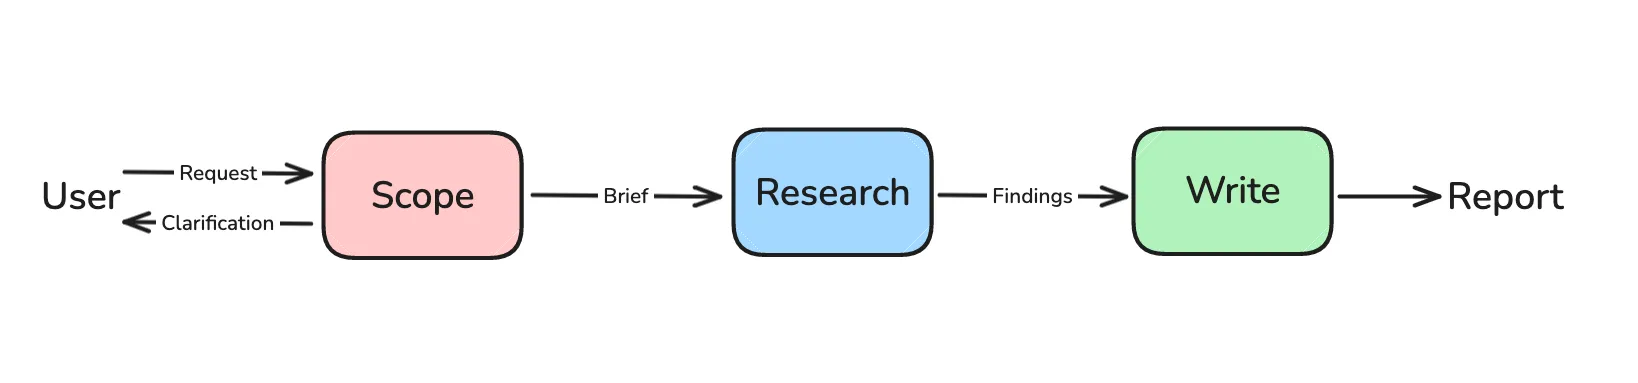

We'll do this in two steps:

1. **User Clarification** - Determines if additional clarification is needed from the user
2. **Brief Generation** - Transforms the conversation into a detailed research brief

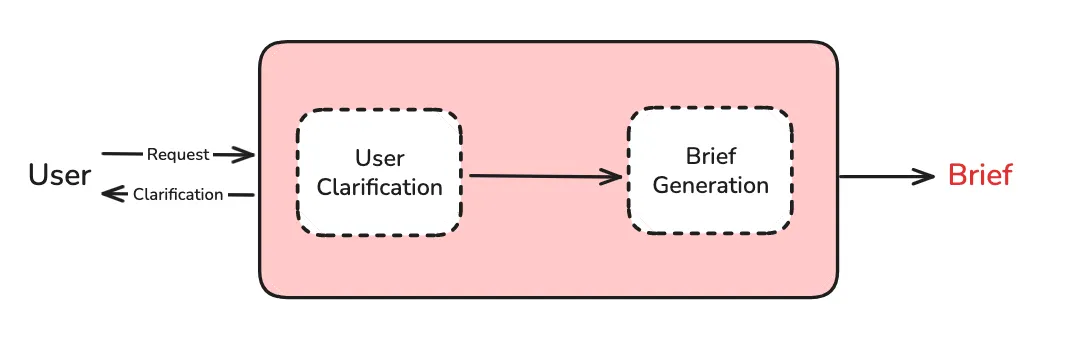

### State and Schemas

First, we'll define the state object and schema. 

The state object serves as our primary mechanism for storing and passing context between different phases of the research workflow. 

We can use it to [write and, later, select context](https://blog.langchain.com/context-engineering-for-agents/) that will be used to guide the research.

In [12]:
%%writefile ../src/deep_research_from_scratch/state.py

from typing import Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    research_brief: Optional[str]

class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

Overwriting ../src/deep_research_from_scratch/state.py


### Prompts

A common challenge in research workflows is that users rarely provide sufficient context in their initial request. Research queries often lack important details like:

- **Scope and boundaries**: What should be included or excluded?
- **Audience and purpose**: Who is this research for and why?
- **Specific requirements**: Are there particular sources, timeframes, or constraints?
- **Clarification of terms**: What do domain-specific terms or acronyms mean?

Rather than making assumptions, we use a structured approach to gather additional context through targeted clarification questions. This ensures we understand the user's true intent before investing time in research that might miss the mark.

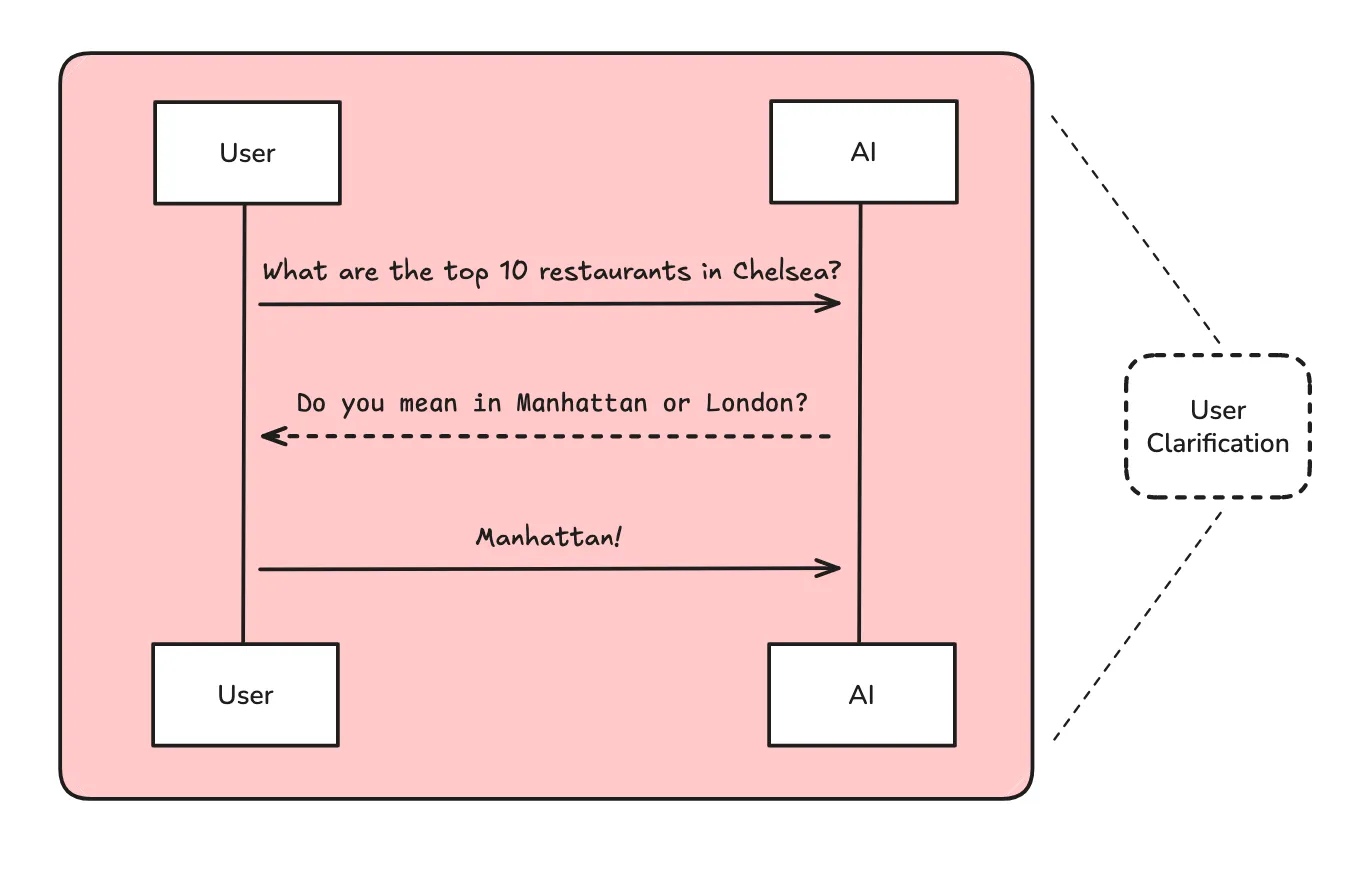

In [17]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import clarify_with_user_instructions
Markdown(clarify_with_user_instructions)

These are the messages that have been exchanged so far from the user asking for the report:  {messages}            

Today's date is {date}.                                                                                            

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for   
you to start research. IMPORTANT: If you can see in the messages history that you have already asked a clarifying  
question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.     

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify. If you need to ask a question,    
follow these guidelines:                                                                                           

 • Be concise while gathering all necessary information                                                            
 • Make sure to gather all the information needed to carry out the research task in a concise, well-structured     
   manner.                                                                                                         
 • Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and
   will be rendered correctly if the string output is passed to a markdown renderer.                               
 • Don't ask for unnecessary information, or information that the user has already provided. If you can see that   
   the user has already provided the information, do not ask for it again.                                         



Respond in valid JSON format with these exact keys: "need_clarification": boolean, "question": "", "verification": 
""                                                                                                                 


If you need to ask a clarifying question, return: "need_clarification": true, "question": "", "verification": ""   


If you do not need to ask a clarifying question, return: "need_clarification": false, "question": "",              
"verification": ""                                                                                                 

For the verification message when no clarification is needed:                                                      

 • Acknowledge that you have sufficient information to proceed                                                     
 • Briefly summarize the key aspects of what you understand from their request                                     
 • Confirm that you will now begin the research process                                                            
 • Keep the message concise and professional

### Workflow

At this stage of the workflow, we use structured output to make clear, deterministic decisions about whether we have sufficient context to proceed with research. This approach has several advantages:
- **Predictability**: The decision logic is explicit and consistent
- **Reliability**: Less prone to hallucination or unexpected behavior
- **Debuggability**: Easy to understand why a particular decision was made
- **Performance**: Faster and more cost-effective than complex reasoning loops

We use LangGraph's [Command system](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command) to control workflow flow while simultaneously updating state. The `Command` object takes two key parameters:
- `goto`: Specifies the next node to execute (or `END` to terminate)
- `update`: Dictionary of state updates to apply before transitioning

This pattern allows our functions to both process data and direct the workflow based on their results, creating a more flexible and maintainable system than traditional static graph structures.

In [16]:
%%writefile ../src/deep_research_from_scratch/scope_research.py

from datetime import datetime
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage,  AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph import MessagesState

from deep_research_from_scratch.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from deep_research_from_scratch.state import AgentState, ClarifyWithUser, ResearchQuestion

from typing import Literal

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# Initialize model
model = init_chat_model(model="openai:gpt-4.1")

# TODO: Resolve "Task clarify_with_user with path ('__pregel_pull', 'clarify_with_user')" wrote to unknown channel branch:to:__end__, ignoring it
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    
    # Structured output 
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages = state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(goto=END, update={"messages": [AIMessage(content=response.question)]})
    else:
        return Command(goto="write_research_brief", update={"messages": [AIMessage(content=response.verification)]})

def write_research_brief(state: AgentState):
    
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state and route to end
    return {
            "research_brief": response.research_brief,
        }

# Build the workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=MessagesState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

scope_research = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/scope_research.py


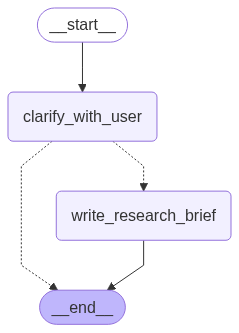

In [15]:
%load_ext autoreload
%autoreload 2

# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.scope_research import deep_researcher_builder

checkpointer = InMemorySaver()
deep_researcher_ntbk_testing = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(deep_researcher_ntbk_testing.get_graph(xray=True).draw_mermaid_png()))

In [18]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = deep_researcher_ntbk_testing.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

Task clarify_with_user with path ('__pregel_pull', 'clarify_with_user') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria are important for determining the 'best' coffee shops (e.g., coffee quality,    │
│ ambiance, location, wifi availability, food options)? Or are you looking for a general top list?                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [20]:
result = deep_researcher_ntbk_testing.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria are important for determining the 'best' coffee shops (e.g., coffee quality,    │
│ ambiance, location, wifi availability, food options)? Or are you looking for a general top list?                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for specifying that coffee quality is the key criterion for determining the best coffee shops in San  │
│ Francisco. I now have enough information to begin researching top coffee shops in San Francisco with a focus on │
│ coffee quality. I will proceed with the research and provide you with a well-informed list.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [21]:
Markdown(result["research_brief"])

I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025.

### LangGraph Studio

This scoping workflow is part of a larger LangGraph application that we'll eventually deploy.

LangGraph is designed to seamlessly support deployment and the files we wrote with `%%writefile` during this notebook form the basis of our application:

#### Key Components

1. **Configuration File** (`langgraph.json`)
   - Specifies dependencies, graphs, and environment variables
   - Defines how the application will be deployed on LangGraph Platform

2. **Application Files and Dependencies**
   - All code written to `/src/deep_research_from_scratch`
   - Dependency specification file (`pyproject.toml`)

Overall, our project structure looks like this:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

#### Key Components

This structure allows the scoping workflow [to be deployed either locally or via a remote server](https://langchain-ai.github.io/langgraph/concepts/deployment_options/).

We can kick off LangGraph server locally with the below command, which will open LangGraph Studio in our browser:

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

### Lesson

In this notebook, we used **structured output** with Pydantic schemas (`ClarifyWithUser`) to control workflow decisions. 

However, there's an alternative approach using **tool binding** that's worth exploring.

#### Our Current Approach: Structured Output

```python
structured_output_model = model.with_structured_output(ClarifyWithUser)
response = structured_output_model.invoke([...])

if response.need_clarification:
    return Command(goto=END, ...)
else:
    return Command(goto="write_research_brief", ...)
```

**Benefits:**
- Predictable, deterministic workflow control
- Clear schema validation  
- Less prone to hallucination
- Faster and more cost-effective

####  Alternative Approach: Tool Calling

Instead of structured output, we could bind tools to the LLM to tell it to go ahead and write the research brief.

```python
def proceed_with_research(verification_message: str) -> str:
    """Call this tool when you have enough information to proceed with research."""
    return f"Proceeding with research: {verification_message}"

# Bind tools to model
llm_with_tools = model.bind_tools([proceed_with_research])

def clarify_with_user(state: AgentState):
    response = llm_with_tools.invoke([...])
    
    # Check if tools were called
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        if tool_call["name"] == "proceed_with_research":
            return Command(goto="write_research_brief", update={"messages": [AIMessage(content=tool_call["args"]["verification_message"])]})
    
    ...
```

#### Try it out

Try implementing the tool calling approach.

You will need to modify the prompts to instruct the LLM to use the tool. 

This also gives to more feedback to add additional tools in this scoping phase, if needed! 